# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
#from cycler import cycler
import numpy as np
import scipy as sc
from scipy import stats
#from scipy.stats import beta

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='bet' and liste[x][1] in ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12']:
        a = '../data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [5]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='bet' and liste[x][1] in ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12']:
        a = 'parametre/test/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de h

## corrcoef

In [6]:
h_bet_e = []
h_bet_m = []
coco_bet = []

h_va_e = []
h_va_m = []
coco_va = []


for x in range(len(exp)) :
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau 
    hs = h*np.logspace(-1., 1., 50)
    
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    h_bet_e.append([])
    h_bet_m.append([])
    coco_bet.append([])
    
    a_anti = param[x]['a_anti']
    h_va_e.append([])
    h_va_m.append([])
    coco_va.append([])
    
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]

    
    for s, mode in enumerate(['expectation', 'max']):
        coco_bet[x].append([])
        coco_va[x].append([])
        
        for block in range(N_blocks):
           
            coef_bet = np.ndarray(50)
            coef_va = np.ndarray(50)
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                for H in range(len(hs)):
                    p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[H], p0=.5)
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)

                    coef_bet[H] = np.corrcoef(results[liste[a]:liste[a+1], block], p_hat)[0][1]
                    coef_va[H] = np.corrcoef(a_anti[block][liste[a]:liste[a+1]], p_hat)[0][1]

                tutu_bet = coef_bet.argmax()
                tutu_va = coef_va.argmax()
                
                p_bar_bet, r_bet, beliefs_bet = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_bet], p0=.5)
                p_hat_bet, r_hat_bet = bcp.readout(p_bar_bet, r_bet, beliefs_bet, mode=mode)
                p_low_bet, p_sup_bet = np.zeros_like(p_hat_bet), np.zeros_like(p_hat_bet)
                
                p_bar_va, r_va, beliefs_va = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_va], p0=.5)
                p_hat_va, r_hat_va = bcp.readout(p_bar_va, r_va, beliefs_va, mode=mode)
                p_low_va, p_sup_va = np.zeros_like(p_hat_va), np.zeros_like(p_hat_va)
                
                for i_trial in range(50):#N_trials):
                    p_low_bet[i_trial], p_sup_bet[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_bet[i_trial]*r_hat_bet[i_trial], b=(1-p_hat_bet[i_trial])*r_hat_bet[i_trial])
                    p_low_va[i_trial], p_sup_va[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_va[i_trial]*r_hat_va[i_trial], b=(1-p_hat_va[i_trial])*r_hat_va[i_trial])

                if mode=='expectation' :
                    h_bet_e[x].append(hs[tutu_bet])
                    h_va_e[x].append(hs[tutu_va])
                elif mode=='max' :
                    h_bet_m[x].append(hs[tutu_bet])
                    h_va_m[x].append(hs[tutu_va])
            
                coco_bet[x][s].append(coef_bet[tutu_bet])
                coco_va[x][s].append(coef_va[tutu_va])
            #----------------------------------------------------
            
            '''for H in range(len(hs)):
                p_bar, r, beliefs = bcp.inference(p[:, block, 0], h=hs[H], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                coef_bet[H] = np.corrcoef(results[:, block], p_hat)[0][1]
                coef_va[H] = np.corrcoef(a_anti[:, block], p_hat)[0][1]

            tutu_bet = coef_bet.argmax()
            tutu_va = coef_va.argmax()
            
            p_bar_bet, r_bet, beliefs_bet = bcp.inference(p[:, block, 0], h=hs[tutu_bet], p0=.5)
            p_hat_bet, r_hat_bet = bcp.readout(p_bar_bet, r_bet, beliefs_bet, mode=mode)
            p_low_bet, p_sup_bet = np.zeros_like(p_hat_bet), np.zeros_like(p_hat_bet)

            p_bar_va, r_va, beliefs_va = bcp.inference(p[:, block, 0], h=hs[tutu_va], p0=.5)
            p_hat_va, r_hat_va = bcp.readout(p_bar_va, r_va, beliefs_va, mode=mode)
            p_low_va, p_sup_va = np.zeros_like(p_hat_va), np.zeros_like(p_hat_va)
                
                
            for i_trial in range(50):#N_trials):
                p_low_bet[i_trial], p_sup_bet[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_bet[i_trial]*r_hat_bet[i_trial], b=(1-p_hat_bet[i_trial])*r_hat_bet[i_trial])
                p_low_va[i_trial], p_sup_va[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_va[i_trial]*r_hat_va[i_trial], b=(1-p_hat_va[i_trial])*r_hat_va[i_trial])'''

            #----------------------------------------------------


In [7]:
new_h_bet_e = []
new_h_bet_m = []
new_h_va_e = []
new_h_va_m = []
for x in range(len(h_bet_e[0])):
    new_h_bet_e.append([])
    new_h_bet_m.append([])
    new_h_va_e.append([])
    new_h_va_m.append([])
    for a in range(len(h_bet_e)):
        new_h_bet_e[x].append(h_bet_e[a][x])
        new_h_bet_m[x].append(h_bet_m[a][x])
        new_h_va_e[x].append(h_va_e[a][x])
        new_h_va_m[x].append(h_va_m[a][x])

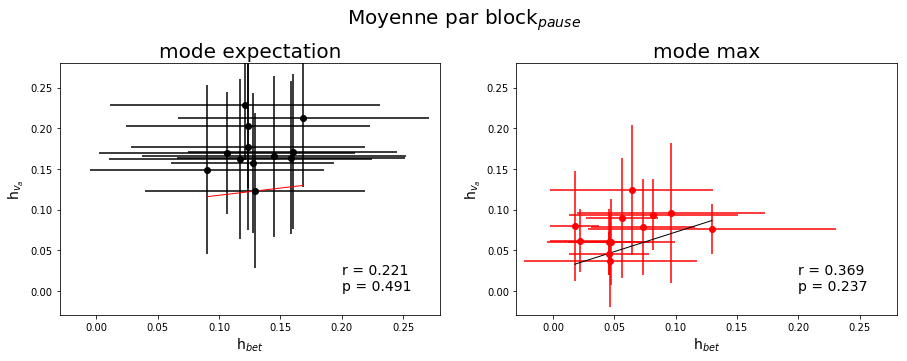

In [8]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

m_bet_e = []
m_va_e = []
m_bet_m = []
m_va_m = []

for x in range(len(h_va_e[0])):
    axs[0].errorbar(np.mean(new_h_bet_e[x]), np.mean(new_h_va_e[x]), xerr=np.std(new_h_bet_e[x]), yerr=np.std(new_h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(new_h_bet_m[x]), np.mean(new_h_va_m[x]), xerr=np.std(new_h_bet_m[x]), yerr=np.std(new_h_va_m[x]),color='r', fmt='o')

    m_bet_e.append(np.mean(new_h_bet_e[x]))
    m_va_e.append(np.mean(new_h_va_e[x]))
    m_bet_m.append(np.mean(new_h_bet_m[x]))
    m_va_m.append(np.mean(new_h_va_m[x]))

    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])


slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_e, m_bet_e)
x_test = np.linspace(np.min(m_bet_e), np.max(m_bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=1)
axs[0].text(0.20,-0.03+(0.28--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_m, m_bet_m)
x_test = np.linspace(np.min(m_bet_m), np.max(m_bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=1)
axs[1].text(0.20,-0.03+(0.28--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

plt.show()

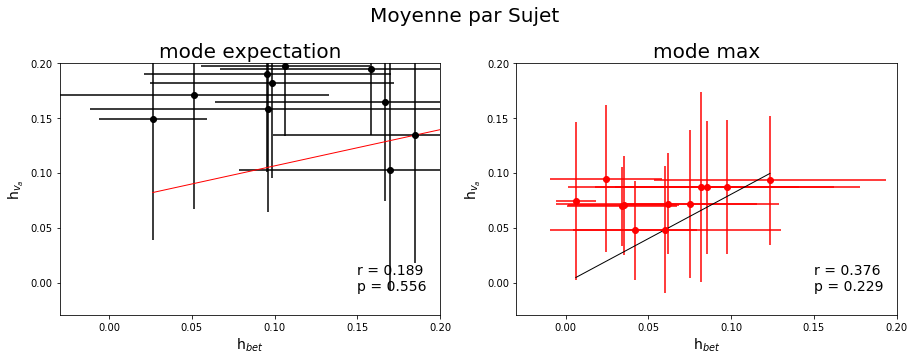

In [9]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

m_bet_e = []
m_va_e = []
m_bet_m = []
m_va_m = []

for x in range(len(h_va_e)):
    axs[0].errorbar(np.mean(h_bet_e[x]), np.mean(h_va_e[x]), xerr=np.std(h_bet_e[x]), yerr=np.std(h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(h_bet_m[x]), np.mean(h_va_m[x]), xerr=np.std(h_bet_m[x]), yerr=np.std(h_va_m[x]),color='r', fmt='o')
    
    m_bet_e.append(np.mean(h_bet_e[x]))
    m_va_e.append(np.mean(h_va_e[x]))
    m_bet_m.append(np.mean(h_bet_m[x]))
    m_va_m.append(np.mean(h_va_m[x]))
    
    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.20,-0.03,0.20])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.20,-0.03,0.20])


slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_e, m_bet_e)
x_test = np.linspace(np.min(m_bet_e), np.max(m_bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=1)
axs[0].text(0.15,-0.03+(0.20--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_m, m_bet_m)
x_test = np.linspace(np.min(m_bet_m), np.max(m_bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=1)
axs[1].text(0.15,-0.03+(0.20--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)


plt.show()

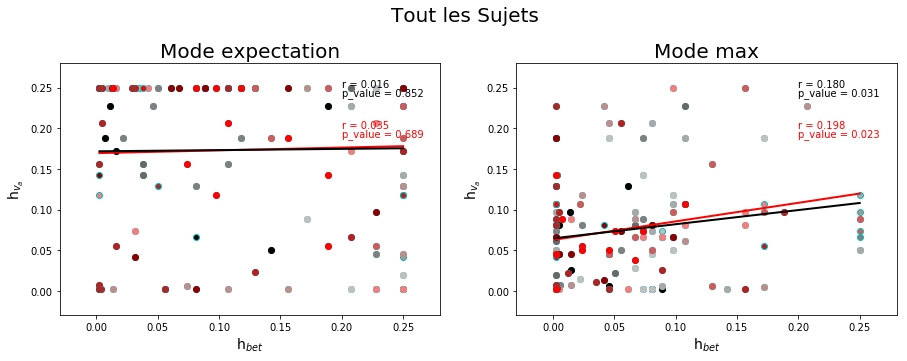

In [10]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Tout les Sujets', fontsize=20, y=1.05)

bet_e = []
bet_m = []
va_e = []
va_m = []
bet_e_0 = []
bet_m_0 = []
va_e_0 = []
va_m_0 = []

for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    for a in range(len(h_va_e)):
        axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors='c')
        axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors='c')
        if a != 0 :
            axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors=color)
            axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors=color)
            bet_e_0.append(h_bet_e[x][a])
            bet_m_0.append(h_bet_m[x][a])
            va_e_0.append(h_va_e[x][a])
            va_m_0.append(h_va_m[x][a])
        bet_e.append(h_bet_e[x][a])
        bet_m.append(h_bet_m[x][a])
        va_e.append(h_va_e[x][a])
        va_m.append(h_va_m[x][a])

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e_0, va_e_0)
x_test = np.linspace(np.min(bet_e_0), np.max(bet_e_0), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=2)
axs[0].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[0].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m_0, va_m_0)
x_test = np.linspace(np.min(bet_m_0), np.max(bet_m_0), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='r', linewidth=2)
axs[1].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)    
axs[1].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e, va_e)
x_test = np.linspace(np.min(bet_e), np.max(bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='k', linewidth=2)
axs[0].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[0].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m, va_m)
x_test = np.linspace(np.min(bet_m), np.max(bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=2)
axs[1].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)    
axs[1].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

#------------------------------------------------------------------------

axs[0].set_title('Mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('Mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()

## MI

In [11]:
# https://matthew-brett.github.io/teaching/mutual_information.html
def mutual_information(hgram):
    """ Mutual information for joint histogram"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [12]:
h_bet_e = []
h_bet_m = []
mimi_bet = []

h_va_e = []
h_va_m = []
mimi_va = []


for x in range(len(exp)) :
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau 
    hs = h*np.logspace(-1., 1., 50)
    
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    h_bet_e.append([])
    h_bet_m.append([])
    mimi_bet.append([])
    
    a_anti = param[x]['a_anti']
    h_va_e.append([])
    h_va_m.append([])
    mimi_va.append([])
    
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]

    
    for s, mode in enumerate(['expectation', 'max']):
        mimi_bet[x].append([])
        mimi_va[x].append([])       
    
    
        for block in range(N_blocks):

            mi_bet = np.ndarray(50)
            mi_va = np.ndarray(50)
            
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                for H in range(len(hs)):
                    p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[H], p0=.5)
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)

                    hist_bet, x_edges, y_edges = np.histogram2d(p_hat,results[liste[a]:liste[a+1], block],bins=20)
                    
                    p_hat_nan = np.ma.masked_array(p_hat, mask=np.isnan(a_anti[block][liste[a]:liste[a+1]])).compressed()
                    va_nan = np.ma.masked_array(a_anti[block][liste[a]:liste[a+1]], mask=np.isnan(a_anti[block][liste[a]:liste[a+1]])).compressed()
                    hist_va, x_edges, y_edges = np.histogram2d(p_hat_nan,va_nan,bins=20)
                    
                    mi_bet[H] = mutual_information(hist_bet)
                    mi_va[H] = mutual_information(hist_va)
                    
                tutu_bet = mi_bet.argmax()
                tutu_va = mi_va.argmax()
                
                p_bar_bet, r_bet, beliefs_bet = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_bet], p0=.5)
                p_hat_bet, r_hat_bet = bcp.readout(p_bar_bet, r_bet, beliefs_bet, mode=mode)
                p_low_bet, p_sup_bet = np.zeros_like(p_hat_bet), np.zeros_like(p_hat_bet)
                
                p_bar_va, r_va, beliefs_va = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_va], p0=.5)
                p_hat_va, r_hat_va = bcp.readout(p_bar_va, r_va, beliefs_va, mode=mode)
                p_low_va, p_sup_va = np.zeros_like(p_hat_va), np.zeros_like(p_hat_va)
                
                for i_trial in range(50):#N_trials):
                    p_low_bet[i_trial], p_sup_bet[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_bet[i_trial]*r_hat_bet[i_trial], b=(1-p_hat_bet[i_trial])*r_hat_bet[i_trial])
                    p_low_va[i_trial], p_sup_va[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_va[i_trial]*r_hat_va[i_trial], b=(1-p_hat_va[i_trial])*r_hat_va[i_trial])

                if mode=='expectation' :
                    h_bet_e[x].append(hs[tutu_bet])
                    h_va_e[x].append(hs[tutu_va])
                elif mode=='max' :
                    h_bet_m[x].append(hs[tutu_bet])
                    h_va_m[x].append(hs[tutu_va])
            
                mimi_bet[x][s].append(mi_bet[tutu_bet])
                mimi_va[x][s].append(mi_va[tutu_va])

In [13]:
new_h_bet_e = []
new_h_bet_m = []
new_h_va_e = []
new_h_va_m = []
for x in range(len(h_bet_e[0])):
    new_h_bet_e.append([])
    new_h_bet_m.append([])
    new_h_va_e.append([])
    new_h_va_m.append([])
    for a in range(len(h_bet_e)):
        new_h_bet_e[x].append(h_bet_e[a][x])
        new_h_bet_m[x].append(h_bet_m[a][x])
        new_h_va_e[x].append(h_va_e[a][x])
        new_h_va_m[x].append(h_va_m[a][x])

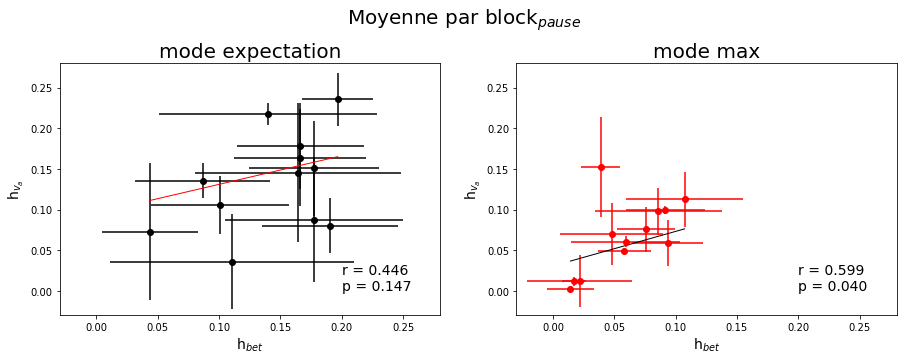

In [14]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

m_bet_e = []
m_va_e = []
m_bet_m = []
m_va_m = []

for x in range(len(h_va_e[0])):
    axs[0].errorbar(np.mean(new_h_bet_e[x]), np.mean(new_h_va_e[x]), xerr=np.std(new_h_bet_e[x]), yerr=np.std(new_h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(new_h_bet_m[x]), np.mean(new_h_va_m[x]), xerr=np.std(new_h_bet_m[x]), yerr=np.std(new_h_va_m[x]),color='r', fmt='o')

    m_bet_e.append(np.mean(new_h_bet_e[x]))
    m_va_e.append(np.mean(new_h_va_e[x]))
    m_bet_m.append(np.mean(new_h_bet_m[x]))
    m_va_m.append(np.mean(new_h_va_m[x]))

    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])


slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_e, m_bet_e)
x_test = np.linspace(np.min(m_bet_e), np.max(m_bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=1)
axs[0].text(0.20,-0.03+(0.28--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_m, m_bet_m)
x_test = np.linspace(np.min(m_bet_m), np.max(m_bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=1)
axs[1].text(0.20,-0.03+(0.28--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

plt.show()

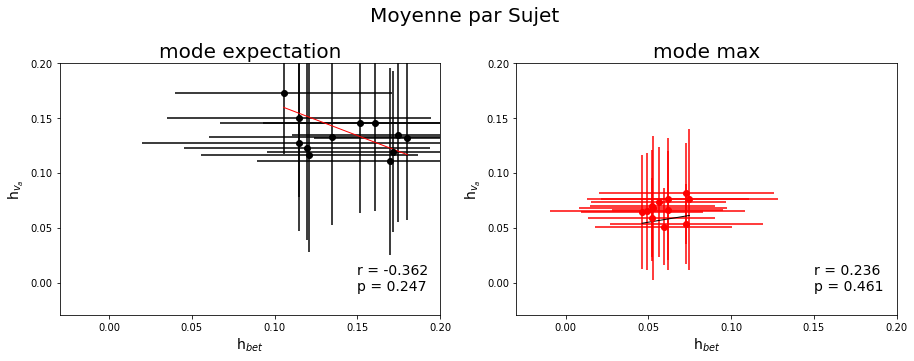

In [15]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

m_bet_e = []
m_va_e = []
m_bet_m = []
m_va_m = []

for x in range(len(h_va_e)):
    axs[0].errorbar(np.mean(h_bet_e[x]), np.mean(h_va_e[x]), xerr=np.std(h_bet_e[x]), yerr=np.std(h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(h_bet_m[x]), np.mean(h_va_m[x]), xerr=np.std(h_bet_m[x]), yerr=np.std(h_va_m[x]),color='r', fmt='o')
    
    m_bet_e.append(np.mean(h_bet_e[x]))
    m_va_e.append(np.mean(h_va_e[x]))
    m_bet_m.append(np.mean(h_bet_m[x]))
    m_va_m.append(np.mean(h_va_m[x]))
    
    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.20,-0.03,0.20])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.20,-0.03,0.20])


slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_e, m_bet_e)
x_test = np.linspace(np.min(m_bet_e), np.max(m_bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=1)
axs[0].text(0.15,-0.03+(0.20--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)

slope, intercept, r_value, p_value, std_err = stats.linregress(m_va_m, m_bet_m)
x_test = np.linspace(np.min(m_bet_m), np.max(m_bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=1)
axs[1].text(0.15,-0.03+(0.20--0.03)/10, 'r = %0.3f \np = %0.3f'%(r_value, p_value), fontsize=14)


plt.show()

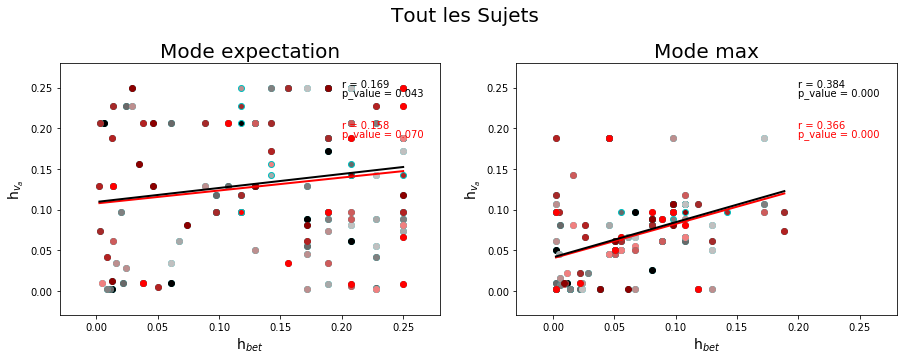

In [16]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Tout les Sujets', fontsize=20, y=1.05)

bet_e = []
bet_m = []
va_e = []
va_m = []
bet_e_0 = []
bet_m_0 = []
va_e_0 = []
va_m_0 = []

for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    for a in range(len(h_va_e)):
        axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors='c')
        axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors='c')
        if a != 0 :
            axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors=color)
            axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors=color)
            bet_e_0.append(h_bet_e[x][a])
            bet_m_0.append(h_bet_m[x][a])
            va_e_0.append(h_va_e[x][a])
            va_m_0.append(h_va_m[x][a])
        bet_e.append(h_bet_e[x][a])
        bet_m.append(h_bet_m[x][a])
        va_e.append(h_va_e[x][a])
        va_m.append(h_va_m[x][a])

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e_0, va_e_0)
x_test = np.linspace(np.min(bet_e_0), np.max(bet_e_0), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=2)
axs[0].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[0].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m_0, va_m_0)
x_test = np.linspace(np.min(bet_m_0), np.max(bet_m_0), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='r', linewidth=2)
axs[1].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)    
axs[1].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e, va_e)
x_test = np.linspace(np.min(bet_e), np.max(bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='k', linewidth=2)
axs[0].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[0].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m, va_m)
x_test = np.linspace(np.min(bet_m), np.max(bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=2)
axs[1].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)    
axs[1].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

#------------------------------------------------------------------------

axs[0].set_title('Mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('Mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()